In [2]:
from upsamplers import load_loftup_checkpoint, norm, unnorm
from featurizers import get_featurizer
from utils import plot_feats

import torch
import torch.nn.functional as F
from PIL import Image, ImageOps
import torchvision.transforms as T
import torchvision.transforms.functional as TF

/root/repos/vlmaps/vlmaps/loftup/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
featurizer_class = "dinov2" # "dinov2", "dinov2b", "dinov2s_reg", "dinov2b_reg", "clip", "siglip", "siglip2"
torch_hub_name = "loftup_dinov2s" # "loftup_dinov2s", "loftup_dinov2b", "loftup_dinov2s_reg", "loftup_dinov2b_reg", "loftup_clip", "loftup_siglip", "loftup_siglip2"

model, patch_size, dim = get_featurizer(featurizer_class)
model = model.to('cuda')
kernel_size = patch_size 
lr_size = 224 // patch_size
load_size = 224

/root/repos/vlmaps/vlmaps/loftup/featurizers/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/repos/vlmaps/vlmaps/loftup/featurizers/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/repos/vlmaps/vlmaps/loftup/featurizers/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/to

In [4]:
upsampler = torch.hub.load('andrehuang/loftup', torch_hub_name, pretrained=True)
upsampler = upsampler.to('cuda')

Using cache found in /root/.cache/torch/hub/andrehuang_loftup_main
/root/.cache/torch/hub/andrehuang_loftup_main/hubconf.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 

In [5]:
image_path = "examples/sa_1.jpg"

In [6]:
transform = T.Compose([
        T.Resize(load_size, T.InterpolationMode.BILINEAR),
        T.CenterCrop(load_size), # Depending on whether you want a center crop
        T.ToTensor(),
        norm])
img = Image.open(image_path).convert("RGB")
normalized_img_tensor = transform(img).unsqueeze(0).to('cuda')
lr_feats = model(normalized_img_tensor) # 1, dim, lr_size, lr_size

/root/repos/vlmaps/vlmaps/loftup/.venv/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Seed set to 0


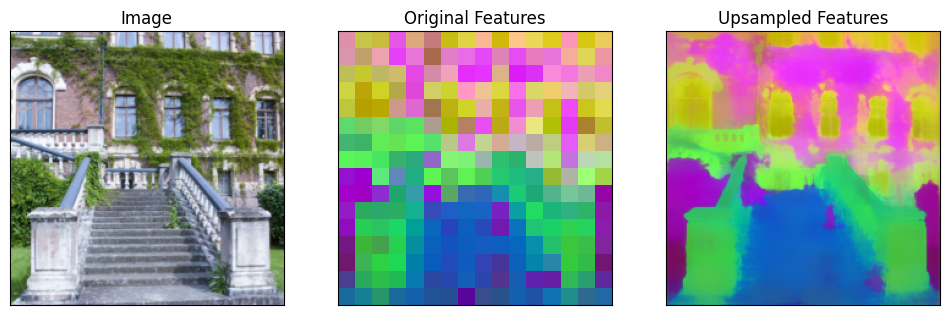

In [7]:
## Upsampling step
hr_feats = upsampler(lr_feats, normalized_img_tensor) # 1, dim, 224, 224

# ## You can also upsample to any shape you want; Just change the guidance image shape
# H, W = 112, 112
# img_tensor_112 = F.interpolate(normalized_img_tensor, size=(H, W), mode='bilinear', align_corners=False)
# hr_feats_112 = upsampler(lr_feats, img_tensor_112) # 1, 384, 112, 112

plot_feats(unnorm(normalized_img_tensor)[0], lr_feats[0], hr_feats[0], 'examples/feats.png')